# Semantc Segmentation (SegNet)

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>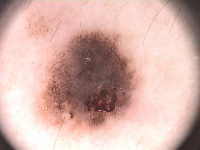</td><td>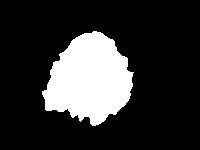</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [1]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar # может быть недоступен

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [2]:
import zipfile
zip_extractor = zipfile.ZipFile('./PH2Dataset.rar')
zip_extractor.extractall('./PH2Dataset')
zip_extractor.close()

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

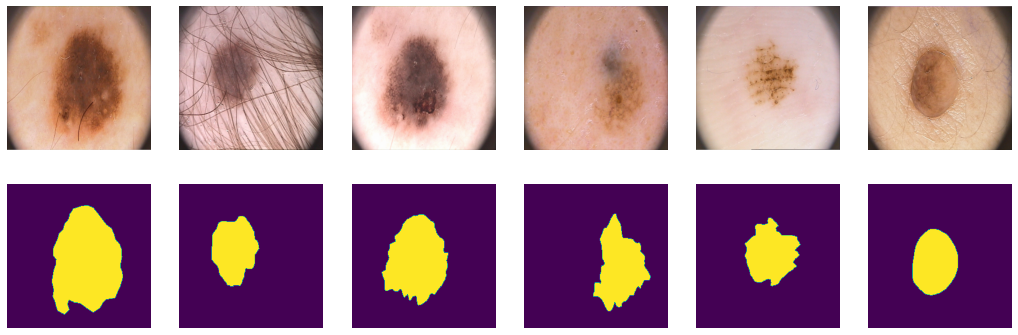

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

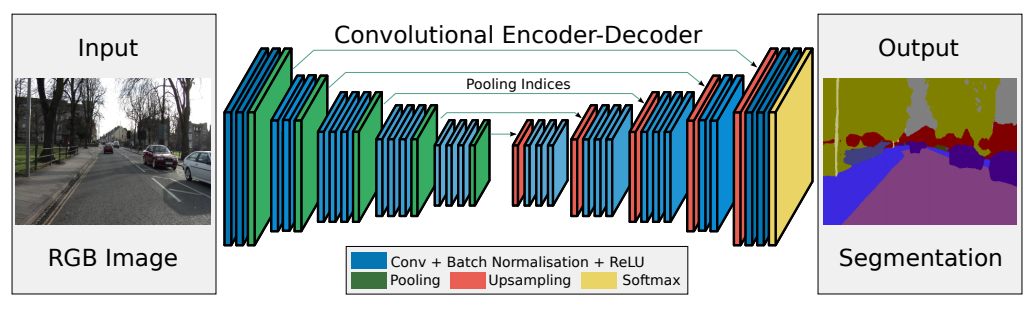

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.05),
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.05)
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck_upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
        )
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
        )
        self.upsample2 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.05),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.05),
        )
        self.upsample3 =  nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)
        b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b)
        b = self.bottleneck_dec_conv(b)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2)) # no activation
        return d3

## Метрика

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске Ground Truth, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на Ground Truth (слева) и Prediction (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou  # 

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_pred, y_real):
    return (y_pred.clamp(min=0) - y_pred * y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))).mean()

## Функция обучения
Запишем цикл обучения в функцию для его многократного использования

In [16]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val, scheduler):
    
    torch.cuda.empty_cache()
    since = time()
    
    X_val, Y_val = next(iter(data_val))
    
    train_losses =  list()
    val_losses = list()
    train_scores = list()
    val_scores = list()
    best_score = 0.0
    print(best_score)
    times = list()

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        time_epoch = time() - tic
        times.append(time_epoch)
        
        print('loss: %f' % avg_loss)
        train_losses.append(avg_loss)
        train_score = score_model(model, metric, data_tr)
        train_scores.append(train_score)

        # show intermediate results
        avg_val_loss = 0 
        with torch.no_grad():  # testing mode
            Y_hat = model(X_val.to(device)).detach().cpu()  # detach and put into cpu
            val_loss = loss_fn(Y_hat, Y_val)
            avg_val_loss += loss
            val_losses.append(avg_val_loss)
            print('val_loss =', val_loss)
            
        val_score = score_model(model, metric, data_val)
        val_scores.append(val_score)
        print('val_score =', val_score)
        
        if val_score > best_score:
            best_score = val_score
            best_model_wts = model.state_dict()
            
        scheduler.step(val_loss)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    model.load_state_dict(best_model_wts)
    info = [train_losses, val_losses, train_scores ,val_scores]
    return info, np.mean(times)

## Инференс

In [17]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [18]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred>0.5, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение


In [22]:
model = SegNet().to(device)

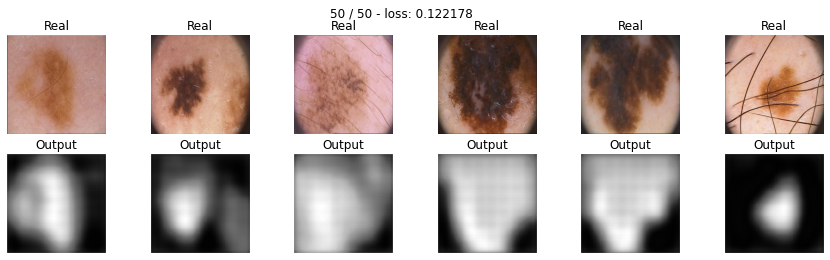

Training complete in 3m 17s


In [23]:
max_epochs = 50
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
info, mean_time = train(model, optimizer, bce_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler)

In [24]:
score_model(model, iou_pytorch, data_val)

0.7904396057128906

Ответьте себе на вопрос: не переобучается ли моя модель?

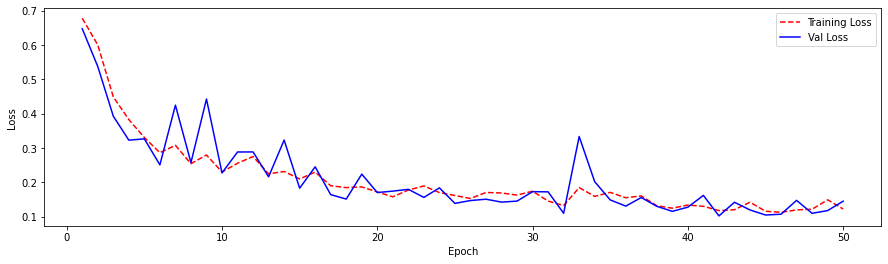

In [25]:
training_loss = [x.item() for x in info[0]]
val_loss = [x.item() for x in info[1]]

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

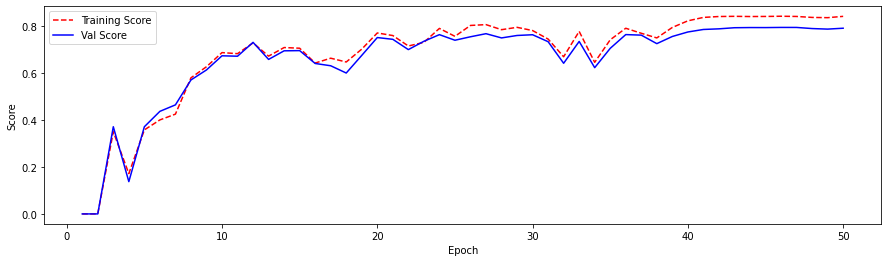

In [26]:
training_score = [x for x in info[2]]
val_score = [x for x in info[3]]

epoch_count = range(1, len(training_score) + 1)

plt.plot(epoch_count, training_score, 'r--')
plt.plot(epoch_count, val_score, 'b-')
plt.legend(['Training Score', 'Val Score'])
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show();

**1. Dice loss:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Однака эта функция не является дифференцируемой (это необходимое свойство для градиентного спуска). В данном случае мы можем приблизить её с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

In [27]:
def dice_loss(y_pred, y_real):
    eps = 1e-8
    y_pred = torch.sigmoid(y_pred)
    
    num = torch.sum(2*y_real*y_pred)
    den = torch.sum(y_real + y_pred)
    
    return 1-1/(256*256)*(num+eps)/(den+eps)

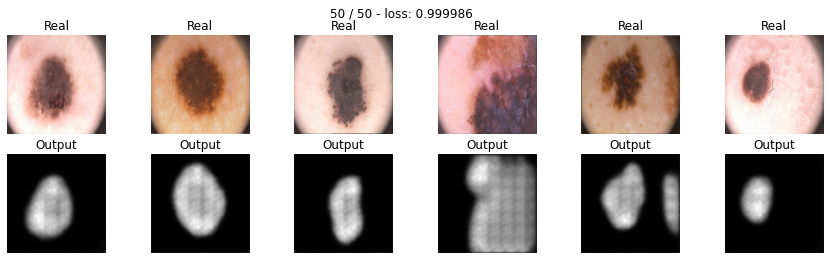

Training complete in 3m 11s


In [28]:
model_dice = SegNet().to(device)

max_epochs = 50
optimizer = optim.Adam(model_dice.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
info, mean_time = train(model_dice, optimizer, dice_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler)

In [29]:
score_model(model_dice, iou_pytorch, data_val)

0.8121098279953003

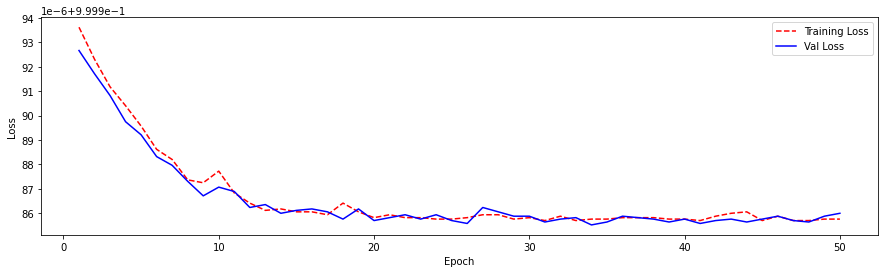

In [30]:
training_loss = [x.item() for x in info[0]]
val_loss = [x.item() for x in info[1]]

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

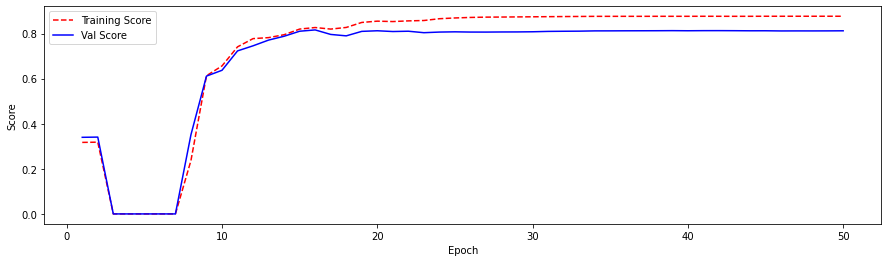

In [31]:
training_score = [x for x in info[2]]
val_score = [x for x in info[3]]

epoch_count = range(1, len(training_score) + 1)

plt.plot(epoch_count, training_score, 'r--')
plt.plot(epoch_count, val_score, 'b-')
plt.legend(['Training Score', 'Val Score'])
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show();

**2. Focal loss**

In [20]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    L = (y_pred.clamp(min=0) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()
    focal_loss = 1*(1-torch.exp(-L))**gamma * L
    return focal_loss

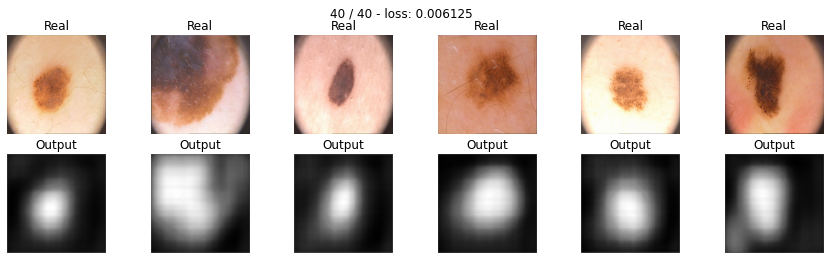

Training complete in 2m 39s


In [21]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
info, mean_time = train(model_focal, optimizer, focal_loss, iou_pytorch, max_epochs, data_tr, data_val, scheduler)

In [22]:
score_model(model_focal, iou_pytorch, data_val)


0.7432736754417419

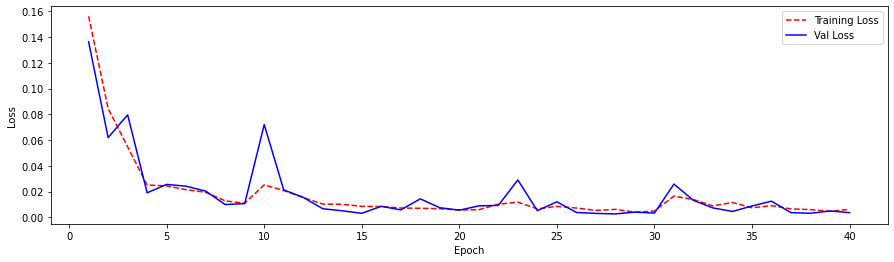

In [23]:
training_loss = [x.item() for x in info[0]]
val_loss = [x.item() for x in info[1]]

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

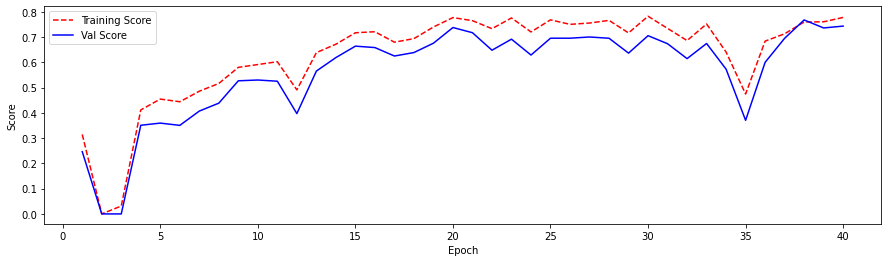

In [24]:
training_score = [x for x in info[2]]
val_score = [x for x in info[3]]

epoch_count = range(1, len(training_score) + 1)

plt.plot(epoch_count, training_score, 'r--')
plt.plot(epoch_count, val_score, 'b-')
plt.legend(['Training Score', 'Val Score'])
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show();